# Predictive Maintenance - Algorithm Selection

## Setup

In [1]:
### IMPORT LIBRARIES
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, normalize
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import SGDClassifier
from sklearn import tree

### READ DATA
##### Needs to be ran from the project directory
train_measurements = pd.read_csv('../datasets/measurements.csv')
train_measurements = train_measurements.sort_values(by=['measurement_time'], ascending=[True])

train_failures = pd.read_csv('../datasets/failures.csv')
train_failures = train_failures.sort_values(by=['failure_time'], ascending=[True])


In [2]:
train_measurements.measurement_time = pd.to_datetime(train_measurements.measurement_time, format="%Y-%m-%d %H:%M:%S")
train_failures.failure_time = pd.to_datetime(train_failures.failure_time)

### MERGE NEXT FAILURE TO MEASUREMENTS
train_combined = pd.merge_asof(
    train_measurements,
    train_failures,
    left_on='measurement_time',
    right_on='failure_time',
    by='gadget_id',
    direction='forward',
)

### TRANSFORM COLUMNS
train_combined['time_to_fail'] = train_combined['failure_time']-train_combined['measurement_time']
train_combined['fail_in_1h'] = np.where(train_combined['time_to_fail']<pd.Timedelta(hours=1), 1, 0)

### CALCULATE RUNNING MEASURES
train_combined = train_combined.reset_index(drop=True)
train_combined = train_combined.sort_values(by=['gadget_id', 'measurement_time'], ascending=[True, True])

train_combined['temperature_6h_std'] = train_combined.groupby('gadget_id')['temperature'].rolling(6).std(ddof=0).reset_index(drop=True)
train_combined['pressure_6h_mean'] = train_combined.groupby('gadget_id')['pressure'].rolling(6).mean().reset_index(drop=True)

train_combined.to_csv('../datasets/train_combined.csv', index=False)

In [3]:
train_combined.head()

,measurement_time,gadget_id,vibration_x,vibration_y,pressure,temperature,Unnamed: 10,Unnamed: 11,failure_time,time_to_fail,fail_in_1h,temperature_6h_std,pressure_6h_mean
0,2020-07-15 00:00:00.000,1,3,7,16.0,44.114437,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 09:56:03.974006640,0,NaN,NaN
7,2020-07-15 01:00:00.000,1,8,3,12.0,34.395177,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 08:56:03.974006640,0,3.453742,15.500000
13,2020-07-15 01:59:59.990,1,10,8,20.0,38.280705,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 07:56:03.984006640,0,3.803752,16.833333
18,2020-07-15 02:59:59.985,1,6,5,20.0,41.878215,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 06:56:03.989006640,0,3.679122,15.166667
25,2020-07-15 03:59:59.980,1,6,9,16.0,39.257268,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 05:56:03.994006640,0,9.337838,13.000000


In [4]:
### SPLIT TO TRAIN AND TEST
X = ['vibration_y', 'pressure_6h_mean', 'temperature_6h_std']
y = 'fail_in_1h'
cols = X + [y]

df_to_split = train_combined.copy()
df_to_split = df_to_split.dropna(subset=cols)
df_to_split = df_to_split.reset_index(drop=True)


In [5]:
##### Create binary bins to 
binner = KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='kmeans')
binner.fit(df_to_split[X])
arr_bins= binner.transform(df_to_split[X])
df_bins = pd.DataFrame(arr_bins)

X = list(df_bins.columns)
cols = X + [y]

df_to_split = pd.concat([df_to_split, df_bins], axis=1)

# train consists of gadgets 1 -4
df_train = df_to_split[df_to_split['gadget_id'].isin([1,2,3,4])].reset_index(drop=True).copy()

# test consists of gfadgets 5 and 6
df_test = df_to_split[df_to_split['gadget_id'].isin([5,6])].reset_index(drop=True).copy()

print(f"Training data: {df_train.shape}")
print(f"Test data: {df_test.shape}")


Training data: (651, 43)
Test data: (327, 43)


In [6]:
df_train.head()

,measurement_time,gadget_id,vibration_x,vibration_y,pressure,temperature,Unnamed: 10,Unnamed: 11,failure_time,time_to_fail,...,20,21,22,23,24,25,26,27,28,29
0,2020-07-15 01:00:00.000,1,8,3,12.0,34.395177,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 08:56:03.974006640,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-07-15 01:59:59.990,1,10,8,20.0,38.280705,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 07:56:03.984006640,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-07-15 02:59:59.985,1,6,5,20.0,41.878215,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 06:56:03.989006640,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-07-15 03:59:59.980,1,6,9,16.0,39.257268,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 05:56:03.994006640,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-07-15 04:59:59.975,1,2,6,10.0,38.927343,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 04:56:03.999006640,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2020-07-16 06:59:59.845,2,9,6,15.0,37.117998,NaN,NaN,2020-07-16 22:08:40.476121540,0 days 15:08:40.631121540,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,2020-07-16 07:59:59.840,2,3,8,16.0,41.319542,NaN,NaN,2020-07-16 22:08:40.476121540,0 days 14:08:40.636121540,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
193,2020-07-16 08:59:59.835,2,1,8,15.0,41.134527,NaN,NaN,2020-07-16 22:08:40.476121540,0 days 13:08:40.641121540,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
194,2020-07-16 09:59:59.830,2,5,9,12.0,45.559509,NaN,NaN,2020-07-16 22:08:40.476121540,0 days 12:08:40.646121540,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Algorithms

In [7]:
### PREDICTION PARAMETERS
w0 = 1
w1 = 8
pos_label = 1


In [8]:
### NEURAL NETWORK
nn = MLPClassifier(
    solver='lbfgs',
    alpha=1e-5,
    hidden_layer_sizes=(10),
    random_state=1,
    max_iter=10000,
    activation='relu',
    tol=0.00001,
)
nn.fit(df_train[X], df_train[y])
df_test['nn'] = nn.predict(df_test[X])


In [9]:
### RANDOM FOREST MODEL
random_forest = RandomForestClassifier(
    min_samples_leaf=7,
    random_state=45,
    n_estimators=50,
    class_weight={0:w0, 1:w1}
)
random_forest.fit(df_train[X], df_train[y])
df_test['rf'] = random_forest.predict(df_test[X])

In [10]:
### LOGISTIC REGRESSION MODEL
log_regr = LogisticRegression(class_weight={0:w0, 1:w1})
log_regr.fit(df_train[X], df_train[y])
df_test['log_regr'] = log_regr.predict(df_test[X])

In [11]:
### LINEAR REGRESSION MODEL
lin_regr = Lasso(alpha=0.1, positive=True)
lin_regr.fit(df_train[X], df_train[y])
df_test['lin_regr'] = lin_regr.predict(df_test[X])
df_test['lin_regr'] = np.where(df_test['lin_regr']>=0.5,1,0)

In [12]:
### KNN MODEL
def knn_weights(knn_y):
    return np.where(knn_y==1, w1, w0)
knn = KNeighborsClassifier(weights=knn_weights)
knn.fit(df_train[X], df_train[y])
df_test['knn'] = knn.predict(df_test[X])

In [13]:
### SVM
svm = SVC(
    class_weight={0:w0, 1:w1},
    C=1,
    random_state=42,
    kernel='linear'
)
svm.fit(df_train[X], df_train[y])
df_test['svm'] = svm.predict(df_test[X])

In [14]:

### NAIVE BAYES
bayes = GaussianNB()
bayes.fit(df_train[X], df_train[y])
df_test['bayes'] = bayes.predict(df_test[X])

In [15]:

clf = SGDClassifier(loss="squared_loss", 
    penalty="l2", 
    max_iter=5)
clf.fit(df_train[X], df_train[y])
df_test['clf'] = clf.predict(df_test[X])

## Results

In [16]:
### PRINT RESULTS
model_summary = []
models = ['rf', 'log_regr', 'lin_regr', 'knn', 'nn', 'svm', 'bayes', 'clf']
for m in models:
    print(f"\n-----------\n{m}")
    try:
        precision = precision_score(df_test['fail_in_1h'], df_test[m], zero_division=0, pos_label=pos_label)
        recall = recall_score(df_test['fail_in_1h'], df_test[m], pos_label=pos_label)
        accuracy = accuracy_score(df_test['fail_in_1h'], df_test[m] )
        conf_matrix = confusion_matrix(df_test['fail_in_1h'], df_test[m] )

        # fpr, tpr, thresholds = roc_curve(df_test['fail_in_1h'], df_test[m])
        # aucscore = auc(fpr, tpr)
        auc = roc_auc_score(df_test['fail_in_1h'], df_test[m])
        f1 = f1_score(df_test['fail_in_1h'], df_test[m])

        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"Accuracy: {accuracy}")
        print(f"Confusion Matrix:\n {conf_matrix}")
        print(f"AUC: {auc}\n")
        print(f"f1: {f1}\n")
        print(df_test[m].value_counts())

        model_summary.append({
            'model': m,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'auc': auc,
            'f1': f1
        })

    except:
        print("Can't calculate score")


-----------
rf
Precision: 0.3106796116504854
Recall: 1.0
Accuracy: 0.7828746177370031
Confusion Matrix:
 [[224  71]
 [  0  32]]
AUC: 0.8796610169491526

f1: 0.4740740740740741

0    224
1    103
Name: rf, dtype: int64

-----------
log_regr
Precision: 0.3
Recall: 0.9375
Accuracy: 0.7798165137614679
Confusion Matrix:
 [[225  70]
 [  2  30]]
AUC: 0.8501059322033898

f1: 0.45454545454545453

0    227
1    100
Name: log_regr, dtype: int64

-----------
lin_regr
Precision: 0.0
Recall: 0.0
Accuracy: 0.9021406727828746
Confusion Matrix:
 [[295   0]
 [ 32   0]]
AUC: 0.5

f1: 0.0

0    327
Name: lin_regr, dtype: int64

-----------
knn
Precision: 0.2857142857142857
Recall: 0.0625
Accuracy: 0.8929663608562691
Confusion Matrix:
 [[290   5]
 [ 30   2]]
AUC: 0.5227754237288136

f1: 0.10256410256410256

0    320
1      7
Name: knn, dtype: int64

-----------
nn
Precision: 0.36363636363636365
Recall: 0.125
Accuracy: 0.8929663608562691
Confusion Matrix:
 [[288   7]
 [ 28   4]]
AUC: 0.550635593220339

f1:

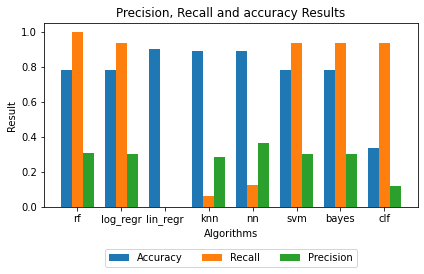

In [17]:
#PRINT RESULT DATAFRAME
#print(df_test[['gadget_id', 'measurement_time'] + cols + models].head(5))

#CREATE IMAGE FOR MODEL COMPARISON
df_summary = pd.DataFrame(model_summary)

x = np.arange(len(df_summary['model']))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, df_summary['accuracy'], width, label='Accuracy')
rects2 = ax.bar(x , df_summary['recall'], width, label='Recall')
rects3 = ax.bar(x + width, df_summary['precision'], width, label='Precision')
# rects4 = ax.bar(x + width, df_summary['auc'], width, label='auc')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Result')
ax.set_xlabel('Algorithms')
ax.set_title('Precision, Recall and accuracy Results')
ax.set_xticks(x)
ax.set_xticklabels(df_summary['model'])
ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol = 3)

fig.tight_layout()

plt.savefig('../img/results.png')

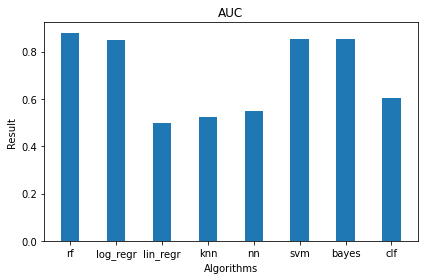

In [18]:
# df_summary = pd.DataFrame(model_summary)

x = np.arange(len(df_summary['model']))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x, df_summary['auc'], width, label='auc')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Result')
ax.set_xlabel('Algorithms')
ax.set_title('AUC')
ax.set_xticks(x)
ax.set_xticklabels(df_summary['model'])
# ax.legend()

fig.tight_layout()
plt.savefig('../img/AUC.png')

In [19]:
df_summary

,model,precision,recall,accuracy,auc,f1
0,rf,0.310680,1.0000,0.782875,0.879661,0.474074
1,log_regr,0.300000,0.9375,0.779817,0.850106,0.454545
2,lin_regr,0.000000,0.0000,0.902141,0.500000,0.000000
3,knn,0.285714,0.0625,0.892966,0.522775,0.102564
4,nn,0.363636,0.1250,0.892966,0.550636,0.186047
5,svm,0.303030,0.9375,0.782875,0.851801,0.458015
6,bayes,0.303030,0.9375,0.782875,0.851801,0.458015
7,clf,0.122449,0.9375,0.336391,0.604343,0.216606


In [20]:
print(df_summary.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
    model &  precision &  recall &  accuracy &       auc &        f1 \\
\midrule
       rf &   0.310680 &  1.0000 &  0.782875 &  0.879661 &  0.474074 \\
 log\_regr &   0.300000 &  0.9375 &  0.779817 &  0.850106 &  0.454545 \\
 lin\_regr &   0.000000 &  0.0000 &  0.902141 &  0.500000 &  0.000000 \\
      knn &   0.285714 &  0.0625 &  0.892966 &  0.522775 &  0.102564 \\
       nn &   0.363636 &  0.1250 &  0.892966 &  0.550636 &  0.186047 \\
      svm &   0.303030 &  0.9375 &  0.782875 &  0.851801 &  0.458015 \\
    bayes &   0.303030 &  0.9375 &  0.782875 &  0.851801 &  0.458015 \\
      clf &   0.122449 &  0.9375 &  0.336391 &  0.604343 &  0.216606 \\
\bottomrule
\end{tabular}

